__Complete all sub-tasks marked with ## TO DO! ## and submit the filled notebook on OLAT__ \
__Using a GPU is recommended here__

### Transfer Learning ###
Aim of this notebook is to implement the concept of transfer learning to train a bigger dataset. We try to compete on a well-known competiton on Kaggle known as Dog Breeds Identification. Read more about it here:

https://www.kaggle.com/c/dog-breed-identification/overview



To train a model on the Dog breeds dataset using transfer learning and submit your results to Kaggle.
Note: Below notebook gives some tips to run the code in pytorch. 

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import shutil
import glob
import cv2
import numpy as np

In [4]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [6]:
from AlexNet import AlexNet
from train_test import start_train_test
from transform import transform_training

In [7]:
####################################################################################################
## TO DO! : Register on Kaggle With Your respective GroupName  (For example: WS20_VDL_GROUP_01)    ##
####################################################################################################

print('Registered on Kaggle with GroupName: WS20_VDL_GROUP_13')

Registered on Kaggle with GroupName: WS20_VDL_GROUP_13


In [8]:
####################################################################################################
## TO DO! : Download the Dog-Breeds dataset in folder "data"                                      ##
## from the Kaggle competition link mentioned above                                               ##
####################################################################################################

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/dog-breed-identification.zip -d /content/data

In [10]:
df = pd.read_csv('/content/data/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
# making data to Imagenet format so can use Pytorch provided datasets and dataloaders

def createDirectoryStructure():
  newPath = '/content/WorkedData/train'
  try:
    os.makedirs(newPath)
  except OSError:
    print ("Creation of the directory %s failed" % newPath)
  else:
    print ("Successfully created the directory %s " % newPath)


def createClassDirectories():
  basePath = '/content/WorkedData/train'
  for breed in df.breed.unique():
    nw = os.path.join(basePath,breed)
    try:
      os.makedirs(nw)
    except OSError:
      print ("Creation of the directory %s failed" % nw)
  print('All Class Directories Created')


def copyImagesToClassDirs():
  count = 0
  for img in glob.glob('/content/data/train/*.jpg'):
    s1 = '/content/data/train/'
    s2 = '.jpg'
    s3 = '/content/WorkedData/train'
    fileName = img[img.index(s1)+len(s1) : img.index(s2)]
    # Get the breedName of the corresponding image/Dog
    breedName = df[df.id == fileName].breed.item()

    # Copy image from source location to destination location
    destPath = os.path.join(s3, breedName)
    print(destPath)
    de = shutil.copy(img, destPath)
    count = count+1
  print(f'Total images moved: {count}')





createDirectoryStructure()
createClassDirectories()
copyImagesToClassDirs()

Streaming output truncated to the last 5000 lines.
/content/WorkedData/train/siberian_husky
/content/WorkedData/train/maltese_dog
/content/WorkedData/train/kuvasz
/content/WorkedData/train/chow
/content/WorkedData/train/affenpinscher
/content/WorkedData/train/malinois
/content/WorkedData/train/sussex_spaniel
/content/WorkedData/train/briard
/content/WorkedData/train/mexican_hairless
/content/WorkedData/train/staffordshire_bullterrier
/content/WorkedData/train/malinois
/content/WorkedData/train/golden_retriever
/content/WorkedData/train/wire-haired_fox_terrier
/content/WorkedData/train/collie
/content/WorkedData/train/leonberg
/content/WorkedData/train/malamute
/content/WorkedData/train/redbone
/content/WorkedData/train/irish_water_spaniel
/content/WorkedData/train/standard_schnauzer
/content/WorkedData/train/dhole
/content/WorkedData/train/chesapeake_bay_retriever
/content/WorkedData/train/labrador_retriever
/content/WorkedData/train/bluetick
/content/WorkedData/train/old_english_sheep

In [12]:
####################################################################################################
## TO DO! : Make your dataset to and dataloaders for the  test data                                ##
####################################################################################################

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms


root_dirl= '/content/WorkedData'

# Loading the data into Dataloader
loaded_data = ImageFolder(root = os.path.join(root_dirl,'train'), transform=transform_training())

In [13]:
####################################################################################################
## TO DO! : Split train data into 20% validation set and make dataloaders for train and val split ##
####################################################################################################

# Splitting the Data to Train and Validation dataset
train_set_len = int(len(loaded_data)*0.8)
val_set_len = len(loaded_data) - train_set_len

train_set, val_set = torch.utils.data.random_split(loaded_data, [train_set_len, val_set_len])

# Loading the data to train and validation dataloader
trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)


In [ ]:
# HINT: 
# One can make their own custom dataset and dataloaders using the CSV file or
# Convert the Dog-breed training dataset into Imagenet Format, where all images of one class are in a
# folder named with class as in the below given format. Standard Pytorch Datasets and Dataloaders can then be applied
# over them
# Root
# |
# |---Class1 ___Img1.png
# |          ___Img2.png
# |
# |---Class2 ___Img3.png
# |          ___Img4.png
# |....
# |....

__Train famous Alexnet model on Dog breeds dataset. It is not easy to train the alexnet model from 
scratch on the Dog breeds data itself. Curious minds can try for once to train Alexnet from scratch. We adopt Transfer Learning here. We 
obtain a pretrained Alexnet model trained on Imagenet and apply transfer learning to it to get better results.__

## Transfer Learning

In [ ]:
####################################################################################################
## TO DO! :  Freeze the weigths of the pretrained alexnet model and change the last classification layer
##from 1000 classes of Imagenet to 120 classes of Dog Breeds, only classification layer should be 
## unfreezed and trainable                                                                        ##
####################################################################################################
# import torchvision.models as models
# pretrained_alexnet = models.alexnet(pretrained=True)


# # Freezing feature parametes of Model
# for param in pretrained_alexnet.features.parameters():
#   param.requires_grad = False

# # Changing the last classification layer
# num_classes = 120
# num_ftrs = pretrained_alexnet.classifier[6].in_features
# pretrained_alexnet.classifier[6] = nn.Linear(num_ftrs, num_classes)

# criterion = nn.CrossEntropyLoss()
# pretrained_alexnet.to('cuda')

# # Below function will directly train your network with the given parameters to 5 epochs
# # You are also free to use function learned in task 1 to train your model here 

# train_loss, test_loss = start_train_test(pretrained_alexnet, trainloader, testloader, criterion)

In [22]:
####################################################################################################
## TO DO! :  Freeze the weigths of the pretrained alexnet model and change the last classification layer
##from 1000 classes of Imagenet to 120 classes of Dog Breeds, only classification layer should be 
## unfreezed and trainable                                                                        ##
####################################################################################################

import torch.nn.functional as F
import torchvision.models as models

pretrained_resnet18 = models.resnet18(pretrained=True)

for param in pretrained_resnet18.parameters():
  param.requires_grad = False

num_classes = 256
num_ftrs = pretrained_resnet18.fc.in_features
pretrained_resnet18.fc = nn.Linear(num_ftrs, num_classes)

In [23]:
pretrained_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
class AddedNet(nn.Module):
  def __init__(self, pretrained_model):
    super(AddedNet, self).__init__()
    self.pretrained = pretrained_model
    self.act1_added = nn.ReLU()
    self.fc2_added = nn.Linear(256, 256)
    self.act2_added = nn.ReLU()
    self.fc3_added = nn.Linear(256, 120)

  def forward(self, x):
    x = self.pretrained(x)
    x = self.act1_added(x)
    x = self.fc2_added(x)
    x = self.act2_added(x)
    x = self.fc3_added(x)
    return x


In [28]:
my_external_model = AddedNet(pretrained_model=pretrained_resnet18)

In [29]:
my_external_model

AddedNet(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [35]:
criterion = nn.CrossEntropyLoss()
my_external_model.to('cuda')
train_loss, test_loss = start_train_test(my_external_model, trainloader, testloader, criterion)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



=> Training Epoch #1, LR=0.0100
| Epoch [  1/ 35] 		Loss: 2.6024 Acc@1: 31.430%

| Validation Epoch #1			Loss: 2.8785 Acc@1: 34.57%
* Test results : Acc@1 = 34.57%
| Elapsed time : 0:01:11

=> Training Epoch #2, LR=0.0100
| Epoch [  2/ 35] 		Loss: 2.1375 Acc@1: 34.450%

| Validation Epoch #2			Loss: 2.7624 Acc@1: 35.55%
* Test results : Acc@1 = 35.55%
| Elapsed time : 0:02:22

=> Training Epoch #3, LR=0.0100
| Epoch [  3/ 35] 		Loss: 2.4872 Acc@1: 34.438%

| Validation Epoch #3			Loss: 2.3970 Acc@1: 35.50%
* Test results : Acc@1 = 35.55%
| Elapsed time : 0:03:34

=> Training Epoch #4, LR=0.0100
| Epoch [  4/ 35] 		Loss: 2.6675 Acc@1: 34.511%

| Validation Epoch #4			Loss: 2.6614 Acc@1: 35.26%
* Test results : Acc@1 = 35.55%
| Elapsed time : 0:04:46

=> Training Epoch #5, LR=0.0100
| Epoch [  5/ 35] 		Loss: 2.3242 Acc@1: 34.964%

| Validation Epoch #5			Loss: 2.5209 Acc@1: 34.62%
* Test results : Acc@1 = 35.55%
| Elapsed time : 0:05:57

=> Training Epoch #6, LR=0.0100
| Epoch [  6/ 35]

## Making Kaggle Submission

In [36]:
from transform import transform_testing
import PIL.Image
import torch.nn.functional as F
import numpy as np

In [39]:
### Not So optimal Code: This can take upto 2 minutes to run: You are free to make an optimal version :) ###
# It iterates over all test images to compute the softmax probablities from the last layer of the network
augment_image = transform_testing()
test_data_root = 'data/test/' 
test_image_list = os.listdir(test_data_root) # list of test files 
result = []
for img_name in test_image_list:
    img = PIL.Image.open(test_data_root + img_name)
    img_tensor = augment_image(img)
    with torch.no_grad():
        #output = pretrained_alexnet(img_tensor.unsqueeze_(0))
        output = my_external_model(img_tensor.unsqueeze_(0).cuda())
        probs = F.softmax(output, dim=1)
    result.append(probs.cpu().numpy())
all_predictions = np.concatenate(result)
print(all_predictions.shape)

(10357, 120)


In [40]:
df = pd.DataFrame(all_predictions)
file_list = os.listdir('WorkedData/train') # list of classes to be provided here
df.columns = sorted(file_list)

# insert clean ids - without folder prefix and .jpg suffix - of images as first column
test_data_root = 'data/test/' # list of all test files here
test_image_list = os.listdir(test_data_root)
df.insert(0, "id", [e[:-4] for e in test_image_list])
df.to_csv(f"sub_1_alexnet.csv", index=False)

### TO DO!: ###
Submit the created CSV file to Kaggle, with a score(cross entropy loss) not more than __2.0__\
Take a snapshot of your evaluation score and  include the image here ...
For example :
![title](snp2.png)

### Group Score from Kaggle - 1.48

![image](WS20_Group_13.PNG)
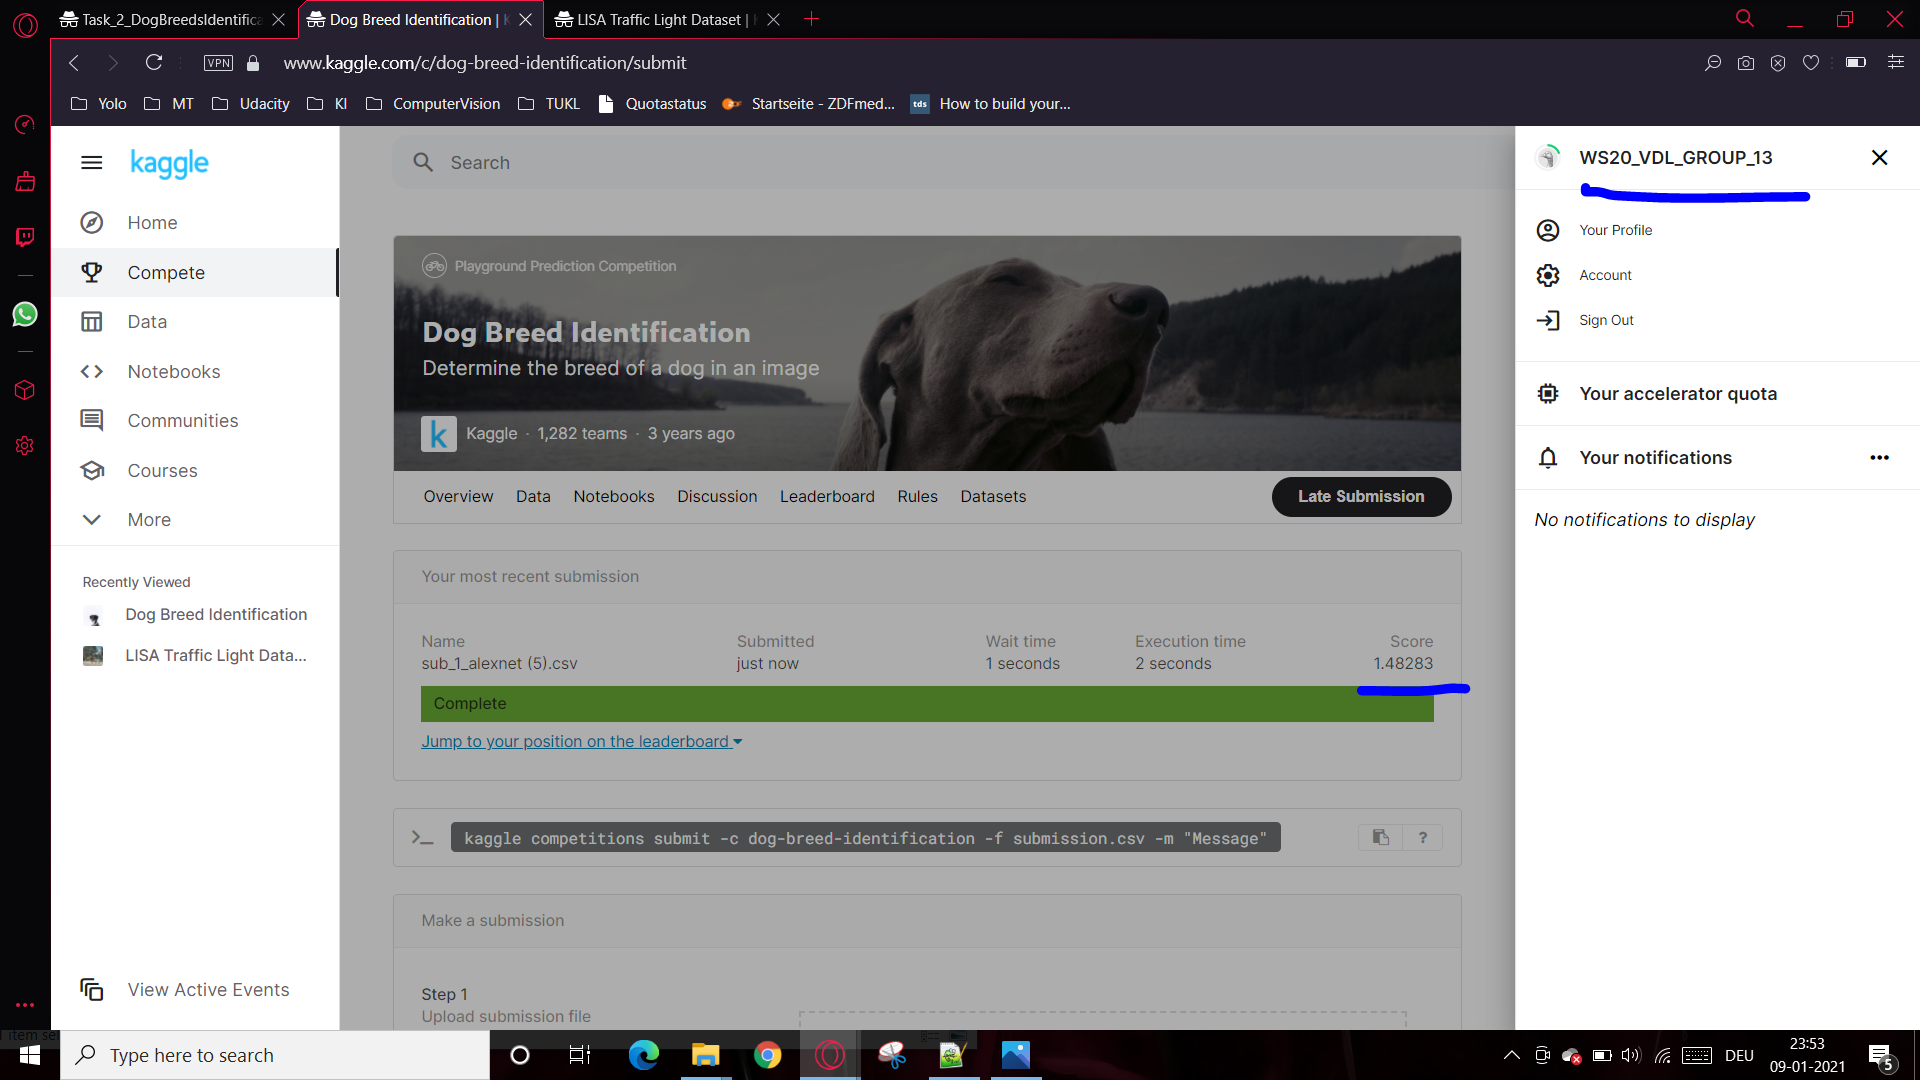

## CHALLENGE  (optional)
Compete against each other, Come up with creative ideas. Try beating the score of __0.3__.

__Hints:__

1. Instead of Alexnet use pretrained resnet 18 model for better accuracy
2. Instead of a just adding the last classification layer, try adding two layers to get a better loss
3. Train some more layers at the end of the network with a very very small learning rate
4. Add Batch Normalizations or Dropout to the layers you have added, (If not present)
5. Add more augmentation to your dataset, see tranform.py file and use auto autoaugment to apply more rigorous data augmentation techniques